# Convolutional Neural Networks in Pytorch

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [99]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Setup MNIST Dataset

In [4]:
# MNIST Image -->
transform = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(root='./../../data/',
                            train=True,
                            download=True,
                            transform=transform)

In [6]:
test_data = datasets.MNIST(root='./../../data/',
                            train=False,
                            download=True,
                            transform=transform)

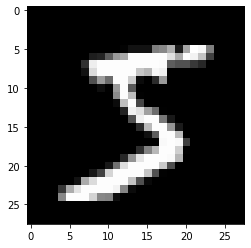

In [7]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap='gray')

In [8]:
# Batch data
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [9]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # Formatting / Making spaces of arrays wider

In [10]:
# First batch.
for images, labels in train_loader:
    break

images.shape

torch.Size([100, 1, 28, 28])

Lables:  [   7    2    3    5    8    5    3    6    9    9    1    3]


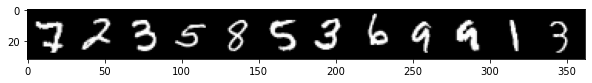

In [11]:
# Print out first 12 images.
im = make_grid(images[:12], nrow=12)
plt.figure(figsize=(10, 4))
# Print first 12 lables.
print('Lables: ', labels[:12].numpy())
# Convert from Color/Width/Height to Width/Height/Color
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

## Classification Using a Traditional Artificial Neural Network

In [12]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layers=[120, 84]):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], output_size)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1) # Multiclass classifications.

In [13]:
torch.manual_seed(101)
model = MultilayerPerceptron()
total_parameter_count = sum([p.numel() for p in model.parameters()])

print(f'Total Model Parameters: {total_parameter_count}') # using a CNN later on will reduce this and make our solution more efficient.

Total Model Parameters: 105214


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
images.shape # We need to make this a single dimension first.

torch.Size([100, 1, 28, 28])

In [16]:
flatten_images = images.view(100, -1)
flatten_images.shape

torch.Size([100, 784])

In [17]:
import time
start_time = time.time()

# Trackers
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_correct = 0
    tst_correct = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_correct += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            accuracy = trn_correct.item()*100/(100*b)
            print(f'Epoch {i}, Batch: {b}, Loss: {loss.item()}, Accuracy: {accuracy}')
            
    train_losses.append(loss)
    train_correct.append(trn_correct)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            predicted = torch.max(y_val.data, 1)[1]
            tst_correct += (predicted==y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_correct)

total_time = time.time() - start_time
print(f'Duration: {total_time/60} mins')

Epoch 0, Batch: 200, Loss: 0.2356238216161728, Accuracy: 83.245
Epoch 0, Batch: 400, Loss: 0.3533070683479309, Accuracy: 87.5325
Epoch 0, Batch: 600, Loss: 0.13734400272369385, Accuracy: 89.58166666666666
Epoch 1, Batch: 200, Loss: 0.24684995412826538, Accuracy: 94.87
Epoch 1, Batch: 400, Loss: 0.14273887872695923, Accuracy: 95.085
Epoch 1, Batch: 600, Loss: 0.0733654797077179, Accuracy: 95.355
Epoch 2, Batch: 200, Loss: 0.08371470123529434, Accuracy: 96.515
Epoch 2, Batch: 400, Loss: 0.06228962913155556, Accuracy: 96.6125
Epoch 2, Batch: 600, Loss: 0.06475143879652023, Accuracy: 96.705
Epoch 3, Batch: 200, Loss: 0.117899090051651, Accuracy: 97.65
Epoch 3, Batch: 400, Loss: 0.05712112784385681, Accuracy: 97.4775
Epoch 3, Batch: 600, Loss: 0.031934332102537155, Accuracy: 97.48833333333333
Epoch 4, Batch: 200, Loss: 0.10764962434768677, Accuracy: 98.09
Epoch 4, Batch: 400, Loss: 0.04543372616171837, Accuracy: 97.97
Epoch 4, Batch: 600, Loss: 0.05657264590263367, Accuracy: 97.99
Epoch 5, 

## Evaluation (ANN)

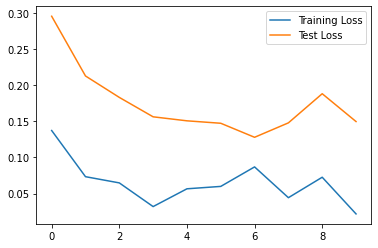

In [18]:
with torch.no_grad():
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.legend()

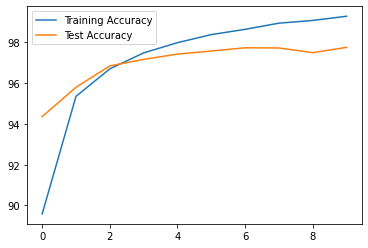

In [19]:
train_accuracy = [t/600 for t in train_correct]
test_accuracy = [t/100 for t in test_correct]

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.legend()

In [20]:
# Evaluate Unseen Data
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted==y_test).sum()

# Accuracy
correct.item() / len(test_data) * 100

97.76

In [21]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 972,    0,    4,    1,    1,    2,    5,    3,    4,    3],
       [   0, 1123,    3,    0,    0,    0,    3,    7,    0,    2],
       [   1,    3, 1004,    3,    1,    0,    1,    8,    3,    0],
       [   3,    2,    4,  985,    0,   11,    1,    1,    3,    1],
       [   0,    0,    2,    0,  966,    3,    1,    2,    2,   11],
       [   0,    1,    0,    8,    0,  864,    3,    0,    4,    3],
       [   1,    2,    2,    0,    5,    2,  943,    1,    1,    0],
       [   0,    0,    3,    4,    1,    2,    0,  983,    2,    0],
       [   2,    4,   10,    3,    0,    6,    1,    4,  950,    3],
       [   1,    0,    0,    6,    8,    2,    0,   19,    5,  986]],
      dtype=int64)

## CNN

### Image Filters & Kernels
Mathematical convolutional kernels that is effectively a matrix that gets multiplied onto a given section of the input image to produce a transformed output. Some typical ones may be outline or blur filters. Strides refer to the steps taken when applying these filters / kernels. A larger stride would result in a smaller output as we are losing resolution when using larger strides. Padding can be used to retain the size of the new image after applying the filter / kernel.

### Pooling Layers
Also known as downsampling layers. I.e. reduces total parameters. Pooling works similarly to filters but for each pixel in the pooling kernel as we pass through the images, we, for example just take the max or average value in the pool / all pizels the kernel is currently considering. Another difference here is we don't do any padding, which results in a decreased resolution for the output of our convolutional layers.

### MNIST with CNN - Intuition

In [22]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [23]:
how_many_channels_in_input_image = 1 # 1 = Greyscale, 3 for RGB.
count_of_filters = 6
kernel_size = 3 # Due to how the convolutional process works, the kernel is always square and so we only need to provide a single value.
stride = 1 # The step size when applying the kernel / filter.
conv1 = nn.Conv2d(in_channels=how_many_channels_in_input_image,
                  out_channels=count_of_filters,
                  kernel_size=kernel_size,
                  stride=stride) # This convolutional layer will take the image as input directly.

conv2 = nn.Conv2d(in_channels=conv1.out_channels,
                  out_channels=16,
                  kernel_size=kernel_size,
                  stride=stride) # This convolutional layer will take the previous layer as an input.

In [24]:
# Grab the first batch.
for i, (X_train, y_train) in enumerate(train_data):
    break

X_train.shape

torch.Size([1, 28, 28])

In [25]:
# Since we're going to be dealing with batches in a bit, let's transform the above to a 4D array instead to make the migration to a batched approach easier.
x = X_train.view(1,1,28,28)

x.shape

torch.Size([1, 1, 28, 28])

In [26]:
x = F.relu(conv1(x))

x.shape

torch.Size([1, 6, 26, 26])

In [27]:
pool_kernel_size = 2
pool_stride = 2
x = F.max_pool2d(x,
                 kernel_size=pool_kernel_size,
                 stride=pool_stride)

x.shape

torch.Size([1, 6, 13, 13])

In [28]:
x = F.relu(conv2(x))

x.shape

torch.Size([1, 16, 11, 11])

In [29]:
x = F.max_pool2d(x,
                 kernel_size=pool_kernel_size,
                 stride=pool_stride)

x.shape

torch.Size([1, 16, 5, 5])

In [30]:
# Flatten convolutional layers output so we can feed it into a dense layer.
x.view(-1, 16*5*5).shape # -1 on this first param will work with an increased batch size too which is great.

torch.Size([1, 400])

### MNIST with CNN - The Real Deal

In [31]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, # 1 for greyscale. 3 for rgb
                               out_channels=6,
                               kernel_size=3,
                               stride=1)
        self.conv2 = nn.Conv2d(in_channels=self.conv1.out_channels,
                               out_channels=16,
                               kernel_size=3,
                               stride=1)
        self.fc1 = nn.Linear(in_features=5*5*16,
                             out_features=120)
        self.fc2 = nn.Linear(in_features=self.fc1.out_features,
                             out_features=84)
        self.fc3 = nn.Linear(in_features=self.fc2.out_features,
                             out_features=10) # Label count / classes to classify.

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, kernel_size=2, stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, kernel_size=2, stride=2)
        X = X.view(-1, self.fc1.in_features)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.log_softmax(self.fc3(X), dim=1)
        
        return X

In [32]:
torch.manual_seed(42)
model = ConvolutionalNetwork()

model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [33]:
total_parameter_count = sum([p.numel() for p in model.parameters()])

total_parameter_count

60074

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train) # No need to flatten here because the convo layers actually accept n-d data :)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum() # true's as 1 and False's as 0, summed.
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 == 0:
            print(f'Epoch: {i}, Batch: {b}, Loss: {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # Check how the model is performing on the test data as we train it, after each Epoch.
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr == (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time

print(f'Total Time: {total / 60} mins.')

Epoch: 0, Batch: 600, Loss: 0.042550548911094666
Epoch: 0, Batch: 1200, Loss: 0.07605952024459839
Epoch: 0, Batch: 1800, Loss: 0.30995577573776245
Epoch: 0, Batch: 2400, Loss: 0.02016785740852356
Epoch: 0, Batch: 3000, Loss: 0.007437355816364288
Epoch: 0, Batch: 3600, Loss: 0.0012245547259226441
Epoch: 0, Batch: 4200, Loss: 0.5557299852371216
Epoch: 0, Batch: 4800, Loss: 0.0668177530169487
Epoch: 0, Batch: 5400, Loss: 0.007983753457665443
Epoch: 0, Batch: 6000, Loss: 0.0668204054236412
Epoch: 1, Batch: 600, Loss: 0.029031146317720413
Epoch: 1, Batch: 1200, Loss: 0.05128370597958565
Epoch: 1, Batch: 1800, Loss: 0.0013509824639186263
Epoch: 1, Batch: 2400, Loss: 0.01731514371931553
Epoch: 1, Batch: 3000, Loss: 0.2662854492664337
Epoch: 1, Batch: 3600, Loss: 0.00023901737586129457
Epoch: 1, Batch: 4200, Loss: 0.0006059271981939673
Epoch: 1, Batch: 4800, Loss: 0.0006372936186380684
Epoch: 1, Batch: 5400, Loss: 0.0007654715445823967
Epoch: 1, Batch: 6000, Loss: 0.06921999901533127
Epoch: 2,

### MNIST with CNN - Valuation

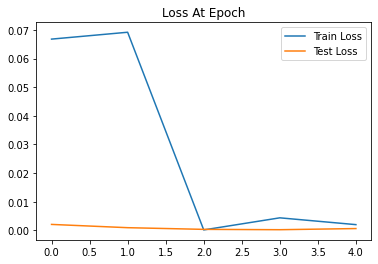

In [39]:
with torch.no_grad():
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss At Epoch')
    plt.legend()

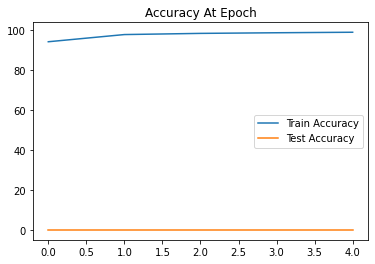

In [40]:
with torch.no_grad():
    plt.plot([t/600 for t in train_correct], label='Train Accuracy')
    plt.plot([t/100 for t in test_correct], label='Test Accuracy')
    plt.title('Accuracy At Epoch')
    plt.legend()

In [41]:
# Valuate all test data.
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [42]:
with torch.no_grad():
    correct = 0
    
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [45]:
overall_accuracy_on_test_data = correct.item() / len(test_data)

overall_accuracy_on_test_data

0.9878

In [46]:
# Confusion matrix.
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 972    0    1    0    0    3    6    1    5    0]
 [   0 1131    0    0    0    0    1    3    0    1]
 [   3    1 1027    2    1    0    1    8    3    0]
 [   0    1    0 1003    0   13    0    1    3    0]
 [   0    0    1    0  974    0    2    4    2    5]
 [   0    0    0    2    0  870    2    0    0    4]
 [   4    2    0    0    1    3  944    0    1    0]
 [   1    0    2    2    0    0    0 1008    1    4]
 [   0    0    1    1    1    1    2    2  956    2]
 [   0    0    0    0    5    2    0    1    3  993]]


### Loading Real Images

#### Loading & Analysis

Download data from here: https://drive.google.com/file/d/1fuFurVV8rcrVTAFPjhQvzGLNdnTi1jWZ/view

In [48]:
import os
from PIL import Image
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

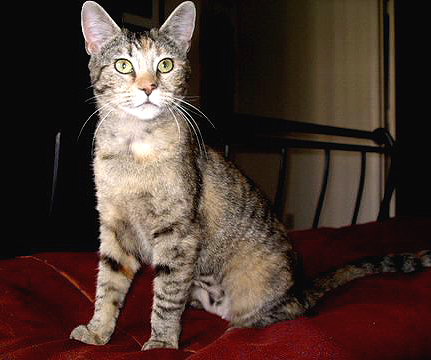

In [49]:
# Test data path to determine top-level path.
with Image.open('../../data/CATS_DOGS/test/CAT/10000.jpg') as im:
    display(im)

In [50]:
path = '../../data/CATS_DOGS'
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder + '/' + img)

len(img_names)

24994

In [51]:
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)

print(len(img_sizes))
print(len(rejected))

In [54]:
df = pd.DataFrame(img_sizes)

df

,0,1
0,431,360
1,500,375
2,500,471
3,500,375
4,320,240
...,...,...
24989,500,375
24990,350,262
24991,250,181
24992,494,500


In [55]:
# Check out some stats on the width.
df[0].describe()

count    24994.000000
mean       404.493518
std        108.941802
min         42.000000
25%        323.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: 0, dtype: float64

In [56]:
# Check out some stats on the height.
df[1].describe()

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: 1, dtype: float64

#### Preprocessing

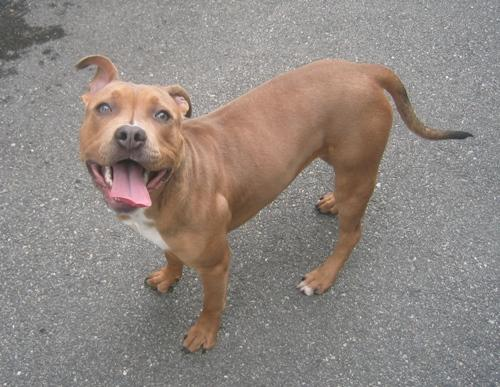

In [58]:
dog = Image.open(path + '/train/DOG/14.jpg')

display(dog)

In [59]:
dog.getpixel((0,0)) # 0 -- 255

(90, 95, 98)

<class 'torch.Tensor'>
torch.Size([3, 224, 224])


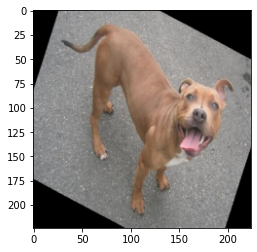

In [72]:
transform = transforms.Compose([ # compose a list of transformations
    transforms.RandomHorizontalFlip(p=1), # Horizontally flip images based on a probability.
    transforms.RandomRotation(30), # Randomly rotate
    transforms.Resize((224,224)),
    #transforms.CenterCrop(250), # Creates a square in the center and crop on it. This helps to make all images the same and so preceeded by a stretch works well.
    transforms.ToTensor()
])
im = transform(dog)

print(type(im))
print(im.shape)

# Matplotlib wants 387, 500, 3
transposed_im = np.transpose(im.numpy(), (1,2,0))

plt.imshow(transposed_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


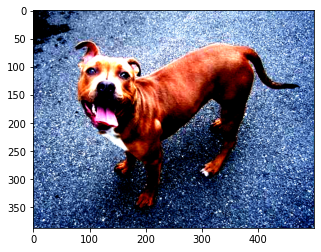

In [73]:
# Specific Normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Lots of pretrained networks like AlexNet uses these pretrained networks.
])

im = transform(dog)

# Matplotlib wants 387, 500, 3
transposed_im = np.transpose(im.numpy(), (1,2,0))

plt.imshow(transposed_im)

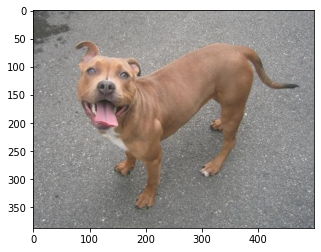

In [76]:
# Denormalize
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))

#### CNN for Custom Images

In [86]:
train_transform = transforms.Compose([
    # Recommended normalization params.
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [78]:
# No need to rotate etc because this is merely used for valuation.
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [89]:
train_data = datasets.ImageFolder(os.path.join(path, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(path, 'test'), transform=test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)
class_names = train_data.classes


In [83]:
class_names

['CAT', 'DOG']

In [90]:
for images, labels in train_loader:
    break

images.shape

torch.Size([10, 3, 224, 224])

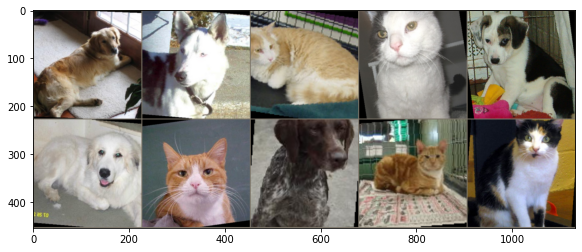

In [91]:
im = make_grid(images, nrow=5)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))

In [93]:
# Calculate FC1 input
img_size = 224
x = (img_size-2) # Lose 2px around the borders as we do the first convolution layer.
x = x / 2 # Due to pooling
x = x - 2 # Lose 2pc around borders again as we do the 2nd convolution layer
x = x / 2 # 2nd pooling layer applied.

round(x)

54

In [94]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, # 1 for greyscale. 3 for rgb
                               out_channels=6,
                               kernel_size=3,
                               stride=1)
        self.conv2 = nn.Conv2d(in_channels=self.conv1.out_channels,
                               out_channels=16,
                               kernel_size=3,
                               stride=1)
        self.fc1 = nn.Linear(in_features=54*54*16, # 16 is for the count of filters.
                             out_features=120)
        self.fc2 = nn.Linear(in_features=self.fc1.out_features,
                             out_features=84)
        self.fc3 = nn.Linear(in_features=self.fc2.out_features,
                             out_features=2) # Classify to cat (1) or dog (2).

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, kernel_size=2, stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, kernel_size=2, stride=2)
        X = X.view(-1, self.fc1.in_features)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.log_softmax(self.fc3(X), dim=1)
        
        return X

In [95]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [97]:
f'{sum([p.numel() for p in model.parameters()])} total parameters.'

'5610222 total parameters.'

In [98]:
start_time = time.time()

epochs = 3
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train) # No need to flatten here because the convo layers actually accept n-d data :)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum() # true's as 1 and False's as 0, summed.
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 == 0:
            print(f'Epoch: {i}, Batch: {b}, Loss: {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # Check how the model is performing on the test data as we train it, after each Epoch.
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr == (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time

print(f'Total Time: {total / 60} mins.')

Epoch: 0, Batch: 600, Loss: 0.7451964020729065
Epoch: 0, Batch: 1200, Loss: 0.5534621477127075
Epoch: 0, Batch: 1800, Loss: 0.8561805486679077
Epoch: 1, Batch: 600, Loss: 0.5772653818130493
Epoch: 1, Batch: 1200, Loss: 0.2594327926635742
Epoch: 1, Batch: 1800, Loss: 0.222377210855484
Epoch: 2, Batch: 600, Loss: 0.30765286087989807
Epoch: 2, Batch: 1200, Loss: 0.6994627118110657
Epoch: 2, Batch: 1800, Loss: 0.5267884731292725
Total Time: 30.90735561052958 mins.


#### CNN (Pretrained) for Custom Images

In [100]:
model = models.alexnet(pretrained=True)

model

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\divanma/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [101]:
# Freeze all parameters so that when we fine-tine the model, the pretrained weights don't get included in the training process.
for param in model.parameters():
    param.requires_grad = False

In [103]:
torch.manual_seed(42)
current_input_for_linear_classifier = 9216
model.classifier = nn.Sequential(
    nn.Linear(current_input_for_linear_classifier, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 2),
    nn.LogSoftmax())

model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [104]:
sum([p.numel() for p in model.parameters()])

11909954

In [105]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [106]:
start_time = time.time()

epochs = 1
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train) # No need to flatten here because the convo layers actually accept n-d data :)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum() # true's as 1 and False's as 0, summed.
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 == 0:
            print(f'Epoch: {i}, Batch: {b}, Loss: {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # Check how the model is performing on the test data as we train it, after each Epoch.
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr == (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time

print(f'Total Time: {total / 60} mins.')

Epoch: 0, Batch: 600, Loss: 0.3906101584434509
Epoch: 0, Batch: 1200, Loss: 0.019208353012800217
Epoch: 0, Batch: 1800, Loss: 0.03520643338561058
Epoch: 1, Batch: 600, Loss: 0.10896474123001099
Epoch: 1, Batch: 1200, Loss: 0.34044942259788513
Epoch: 1, Batch: 1800, Loss: 0.06442517042160034
Epoch: 2, Batch: 600, Loss: 0.3629544973373413
Epoch: 2, Batch: 1200, Loss: 0.11406220495700836
Epoch: 2, Batch: 1800, Loss: 0.037496231496334076
Total Time: 57.624111859003705 mins.
